In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize, forest_minimize, dummy_minimize
from skopt.plots import plot_convergence
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RepeatedKFold, train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import sklearn
from matplotlib import pyplot as plt
from sklearn import tree
import lightgbm as lgb
from lightgbm import LGBMRegressor

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

#### Creating target

In [3]:
target_col=list(set(train.columns) ^ set(test.columns))
print(target_col)

['SalePrice']


In [4]:
cols = train.columns

In [5]:
y = train['SalePrice']

In [6]:
train = train.drop('SalePrice', 1)

In [7]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


#### Remaking probability distribution of target to bell curved type

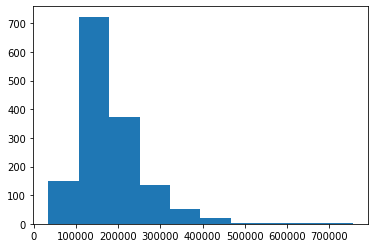

In [8]:
plt.hist(y)
plt.show()

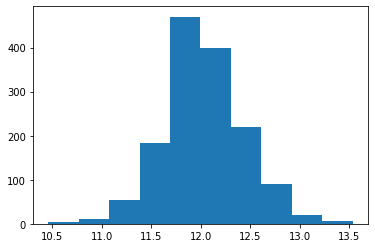

In [9]:
target = np.log(y)
plt.hist(target)
plt.show()

#### Exploring categorical features

In [10]:
cat_cols = train.select_dtypes(include='object').columns

In [11]:
print(f'Number of categorical features: {len(cat_cols)},\nList of features: {cat_cols.values}') 

Number of categorical features: 43,
List of features: ['MSZoning' 'Street' 'Alley' 'LotShape' 'LandContour' 'Utilities'
 'LotConfig' 'LandSlope' 'Neighborhood' 'Condition1' 'Condition2'
 'BldgType' 'HouseStyle' 'RoofStyle' 'RoofMatl' 'Exterior1st'
 'Exterior2nd' 'MasVnrType' 'ExterQual' 'ExterCond' 'Foundation'
 'BsmtQual' 'BsmtCond' 'BsmtExposure' 'BsmtFinType1' 'BsmtFinType2'
 'Heating' 'HeatingQC' 'CentralAir' 'Electrical' 'KitchenQual'
 'Functional' 'FireplaceQu' 'GarageType' 'GarageFinish' 'GarageQual'
 'GarageCond' 'PavedDrive' 'PoolQC' 'Fence' 'MiscFeature' 'SaleType'
 'SaleCondition']


#### Label encoding

In [12]:
def label_encoding(train, test, columns):
    for col in columns:
        train[col] = train[col].fillna(-1)#filling missing values with -1
        test[col] = test[col].fillna(-1)#filling missing values with -1
        encoder = LabelEncoder()
        encoder.fit(train[col][train[col] != -1].astype(str))
        train[col][train[col] != -1] = encoder.transform(train[col][train[col] != -1].astype(str))#encoding only not missing values
        test[col][test[col] != -1] = encoder.transform(test[col][test[col] != -1].astype(str))#encoding only not missing values
        keys = encoder.classes_
        values = encoder.transform(encoder.classes_)
        dictionary = dict(zip(keys, values))
        print(f'Column: {col}, values: {dictionary}')
    return train, test

In [13]:
train, test = label_encoding(train, test, cat_cols)

Column: MSZoning, values: {'C (all)': 0, 'FV': 1, 'RH': 2, 'RL': 3, 'RM': 4}
Column: Street, values: {'Grvl': 0, 'Pave': 1}
Column: Alley, values: {'Grvl': 0, 'Pave': 1}
Column: LotShape, values: {'IR1': 0, 'IR2': 1, 'IR3': 2, 'Reg': 3}
Column: LandContour, values: {'Bnk': 0, 'HLS': 1, 'Low': 2, 'Lvl': 3}
Column: Utilities, values: {'AllPub': 0, 'NoSeWa': 1}
Column: LotConfig, values: {'Corner': 0, 'CulDSac': 1, 'FR2': 2, 'FR3': 3, 'Inside': 4}
Column: LandSlope, values: {'Gtl': 0, 'Mod': 1, 'Sev': 2}
Column: Neighborhood, values: {'Blmngtn': 0, 'Blueste': 1, 'BrDale': 2, 'BrkSide': 3, 'ClearCr': 4, 'CollgCr': 5, 'Crawfor': 6, 'Edwards': 7, 'Gilbert': 8, 'IDOTRR': 9, 'MeadowV': 10, 'Mitchel': 11, 'NAmes': 12, 'NPkVill': 13, 'NWAmes': 14, 'NoRidge': 15, 'NridgHt': 16, 'OldTown': 17, 'SWISU': 18, 'Sawyer': 19, 'SawyerW': 20, 'Somerst': 21, 'StoneBr': 22, 'Timber': 23, 'Veenker': 24}
Column: Condition1, values: {'Artery': 0, 'Feedr': 1, 'Norm': 2, 'PosA': 3, 'PosN': 4, 'RRAe': 5, 'RRAn': 

/Users/nikkirpa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/nikkirpa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Column: Foundation, values: {'BrkTil': 0, 'CBlock': 1, 'PConc': 2, 'Slab': 3, 'Stone': 4, 'Wood': 5}
Column: BsmtQual, values: {'Ex': 0, 'Fa': 1, 'Gd': 2, 'TA': 3}
Column: BsmtCond, values: {'Fa': 0, 'Gd': 1, 'Po': 2, 'TA': 3}
Column: BsmtExposure, values: {'Av': 0, 'Gd': 1, 'Mn': 2, 'No': 3}
Column: BsmtFinType1, values: {'ALQ': 0, 'BLQ': 1, 'GLQ': 2, 'LwQ': 3, 'Rec': 4, 'Unf': 5}
Column: BsmtFinType2, values: {'ALQ': 0, 'BLQ': 1, 'GLQ': 2, 'LwQ': 3, 'Rec': 4, 'Unf': 5}
Column: Heating, values: {'Floor': 0, 'GasA': 1, 'GasW': 2, 'Grav': 3, 'OthW': 4, 'Wall': 5}
Column: HeatingQC, values: {'Ex': 0, 'Fa': 1, 'Gd': 2, 'Po': 3, 'TA': 4}
Column: CentralAir, values: {'N': 0, 'Y': 1}
Column: Electrical, values: {'FuseA': 0, 'FuseF': 1, 'FuseP': 2, 'Mix': 3, 'SBrkr': 4}
Column: KitchenQual, values: {'Ex': 0, 'Fa': 1, 'Gd': 2, 'TA': 3}
Column: Functional, values: {'Maj1': 0, 'Maj2': 1, 'Min1': 2, 'Min2': 3, 'Mod': 4, 'Sev': 5, 'Typ': 6}
Column: FireplaceQu, values: {'Ex': 0, 'Fa': 1, 'Gd': 2, 

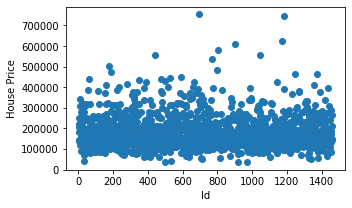

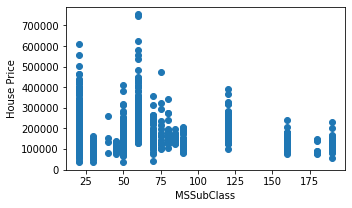

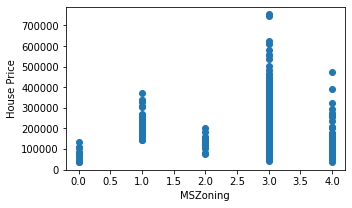

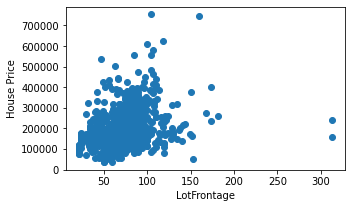

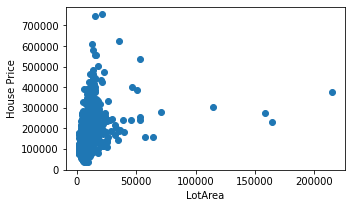

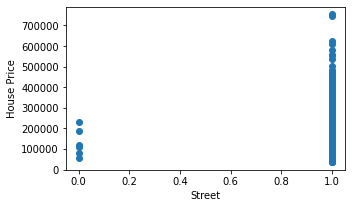

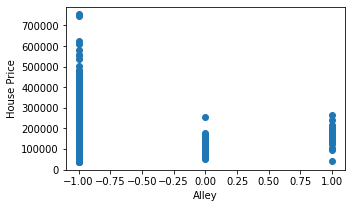

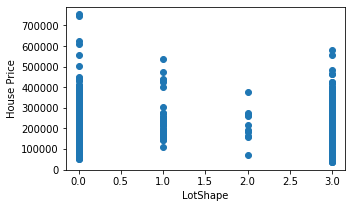

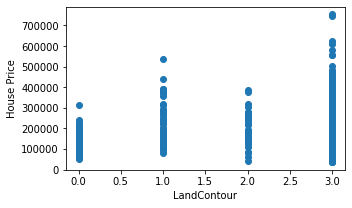

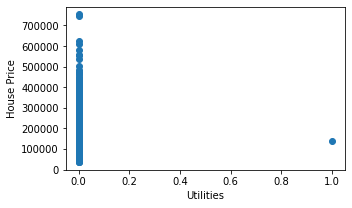

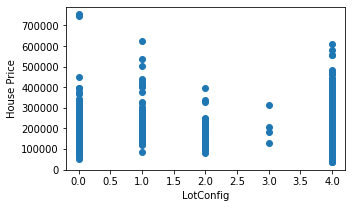

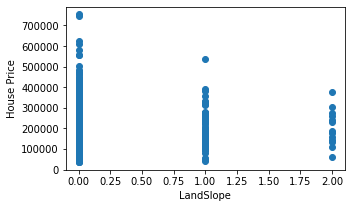

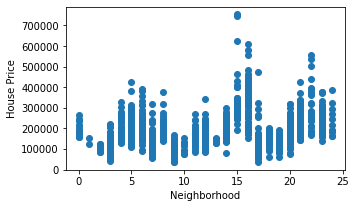

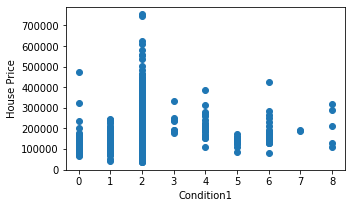

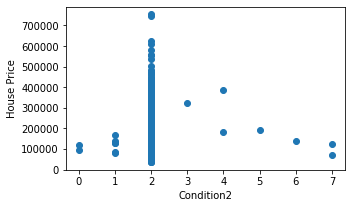

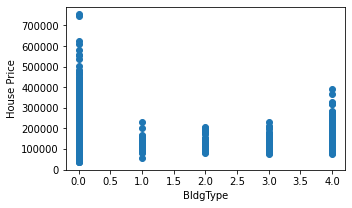

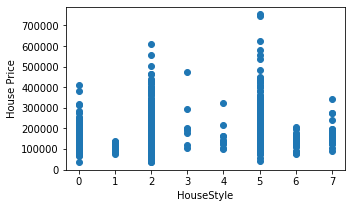

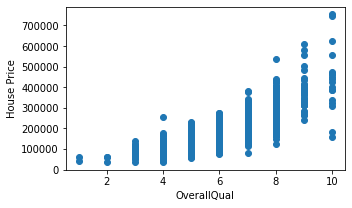

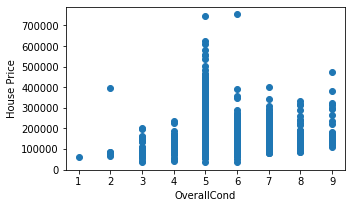

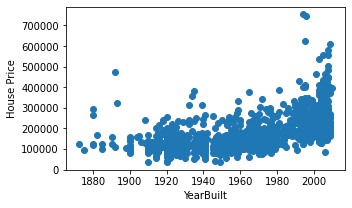

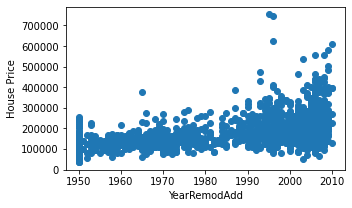

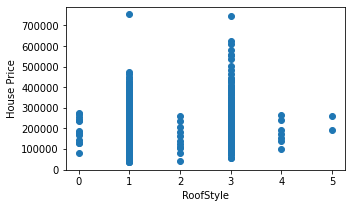

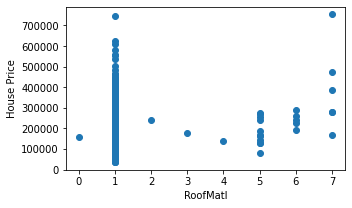

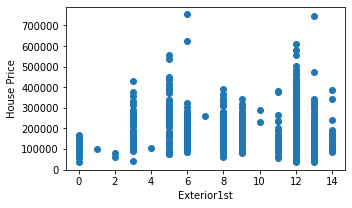

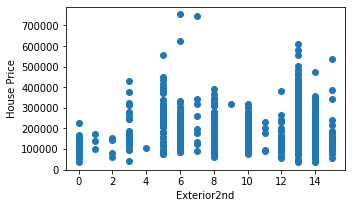

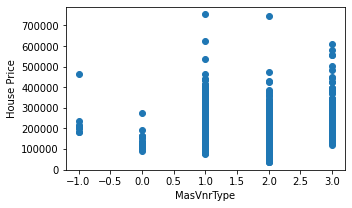

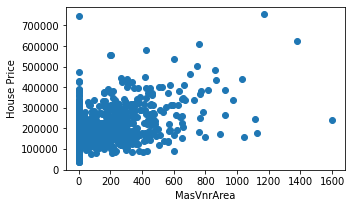

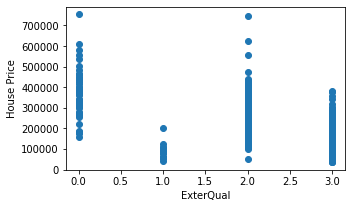

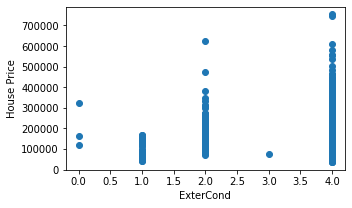

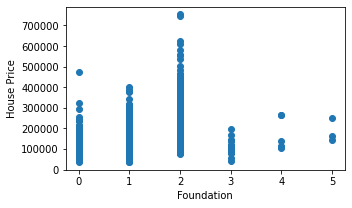

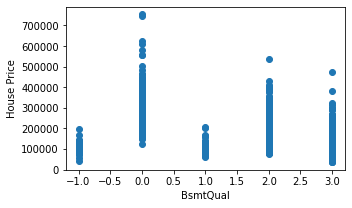

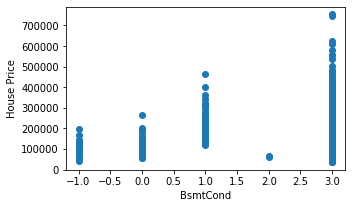

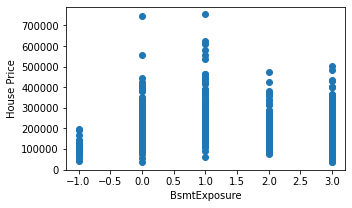

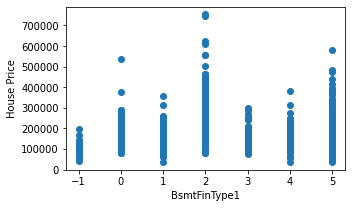

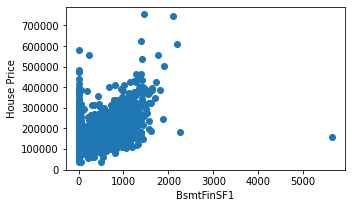

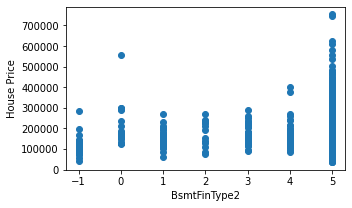

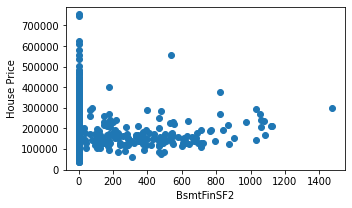

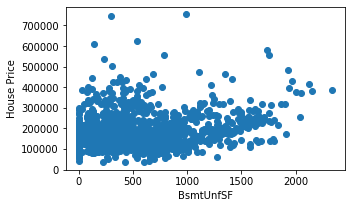

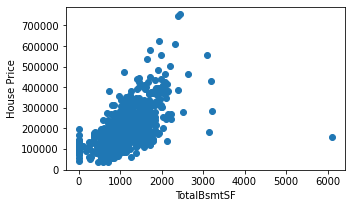

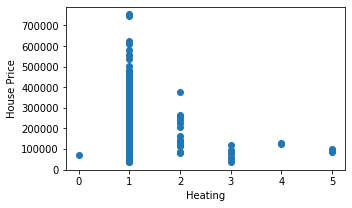

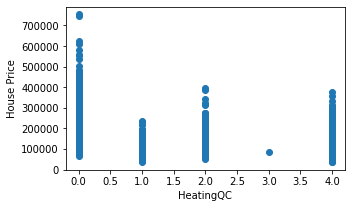

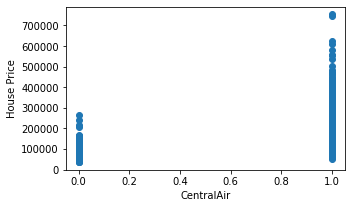

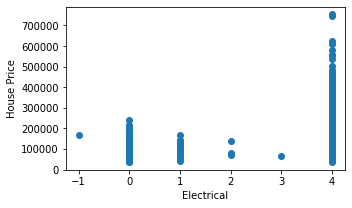

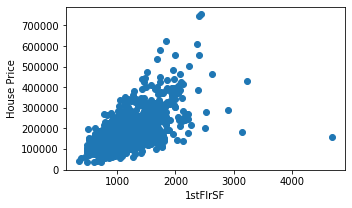

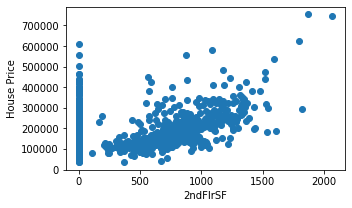

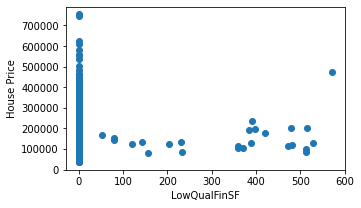

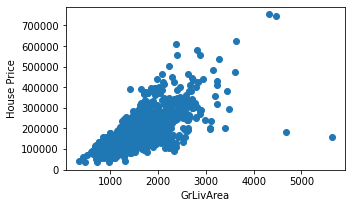

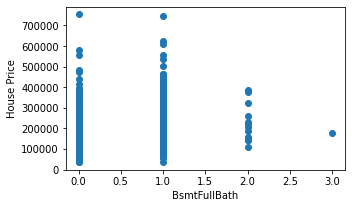

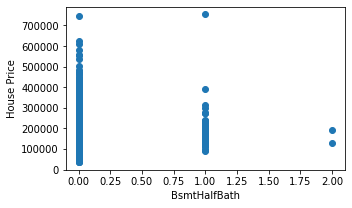

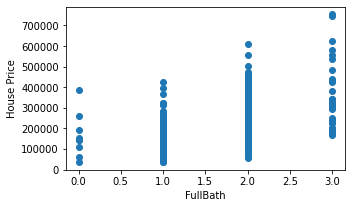

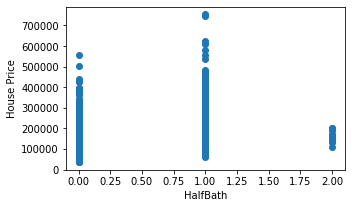

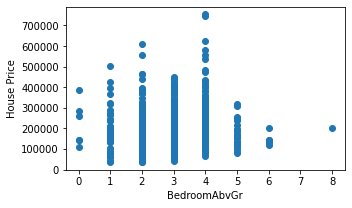

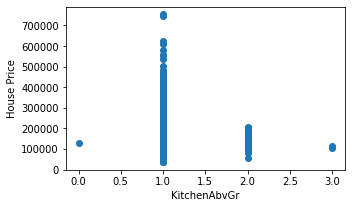

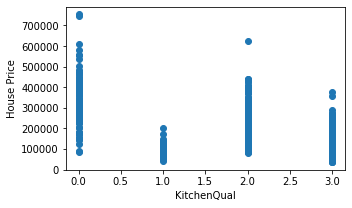

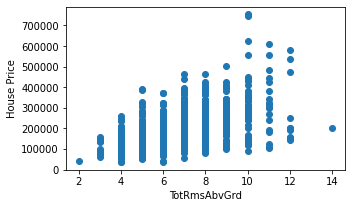

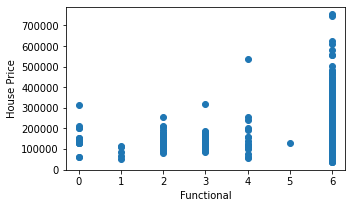

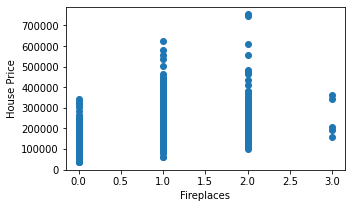

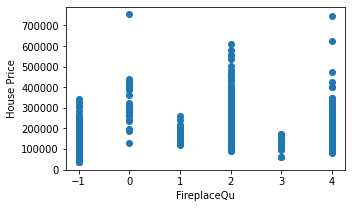

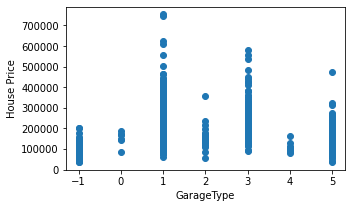

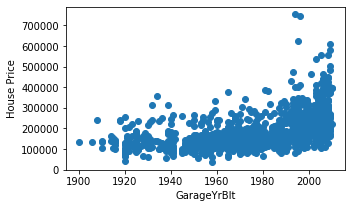

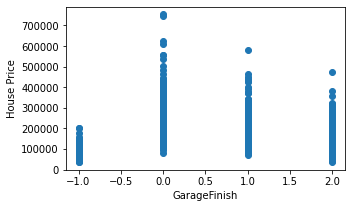

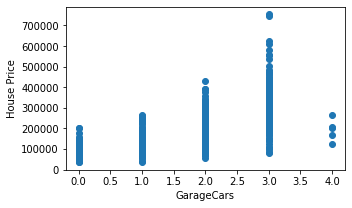

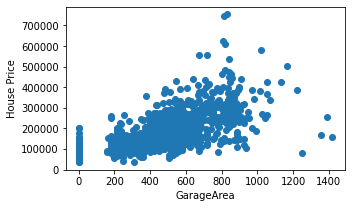

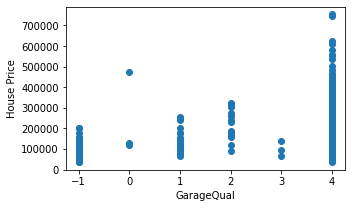

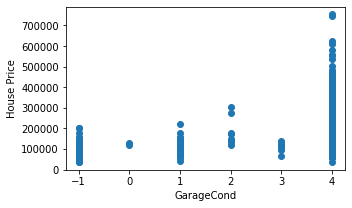

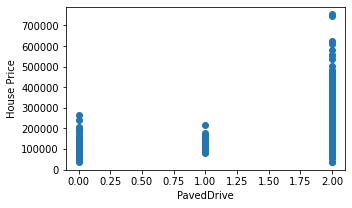

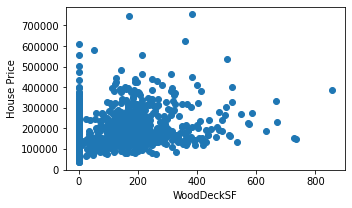

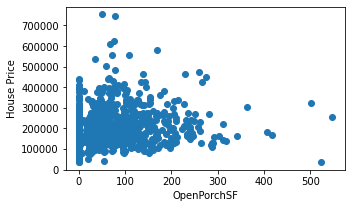

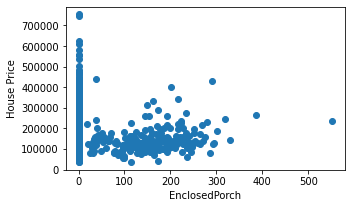

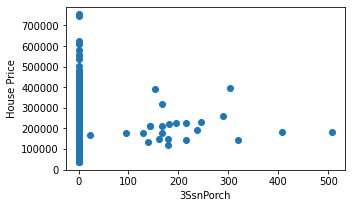

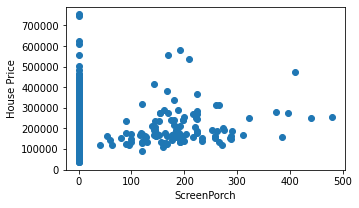

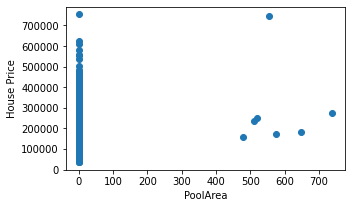

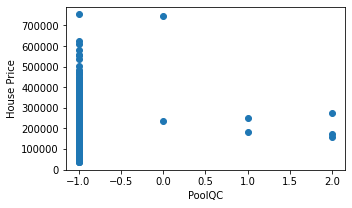

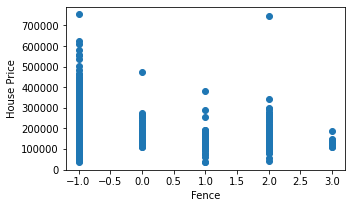

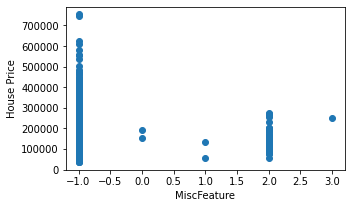

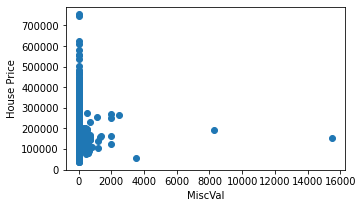

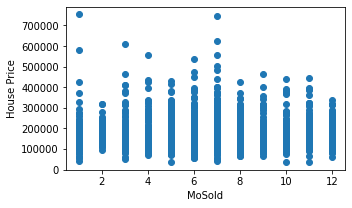

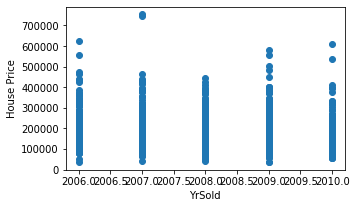

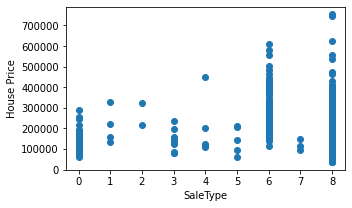

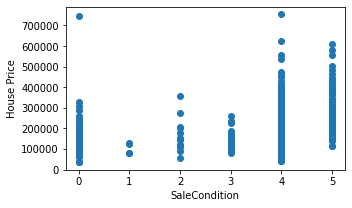

In [14]:
for col in train.columns:
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.scatter(x = train[col], y = y)
    plt.xlabel(col)
    plt.ylabel("House Price")

    plt.show()

#### Deal with missing values

In [15]:
num_col = train.select_dtypes(include = np.number).columns.tolist()

In [16]:
def fill_zeros(train, test, columns):
    for col in columns:
        train[col].fillna(train[col].mean(), inplace=True)
        test[col].fillna(test[col].mean(), inplace=True)
    return train, test

In [17]:
train, test = fill_zeros(train, test, num_col)

#### Dividing to train and validation sets

In [18]:
train, val_set, target, val_target = train_test_split(train, target, random_state=1, test_size=0.2)

In [19]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)
val_set_scaled = scaler.transform(val_set)
val_target = val_target.to_numpy()
target = target.to_numpy()

Defining train validation method and sci-kit optimise

## Descision Tree
I'am initializing descision tree regressor for finding best features in dataset

#### Hyperparameters tuning using GridSearch

In [20]:
param_grid = {
              "max_depth": [1, 2, 5, 10, 20, 25, 30],
              "min_samples_leaf": [1, 5, 10, 15, 20, 30],
              "max_features": [1.0, 0.9, 0.8, 0.7, 0.6]
              }

model_tree = DecisionTreeRegressor(random_state=42)

grid_search = GridSearchCV(model_tree,param_grid=param_grid,cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

grid_search.fit(train_scaled, target)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=42, splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [1, 2, 5, 10, 20, 25, 30],
                         'max_features': [1.0, 0.9, 0.8, 0.7, 0.6],
                         'min_samples_leaf': [1, 5, 10, 15, 20, 30]},
 

In [21]:
grid_search.best_params_, grid_search.best_score_

({'max_depth': 10, 'max_features': 0.9, 'min_samples_leaf': 10},
 -0.13583385516274157)

In [22]:
model_tree = grid_search.best_estimator_

Getting best model

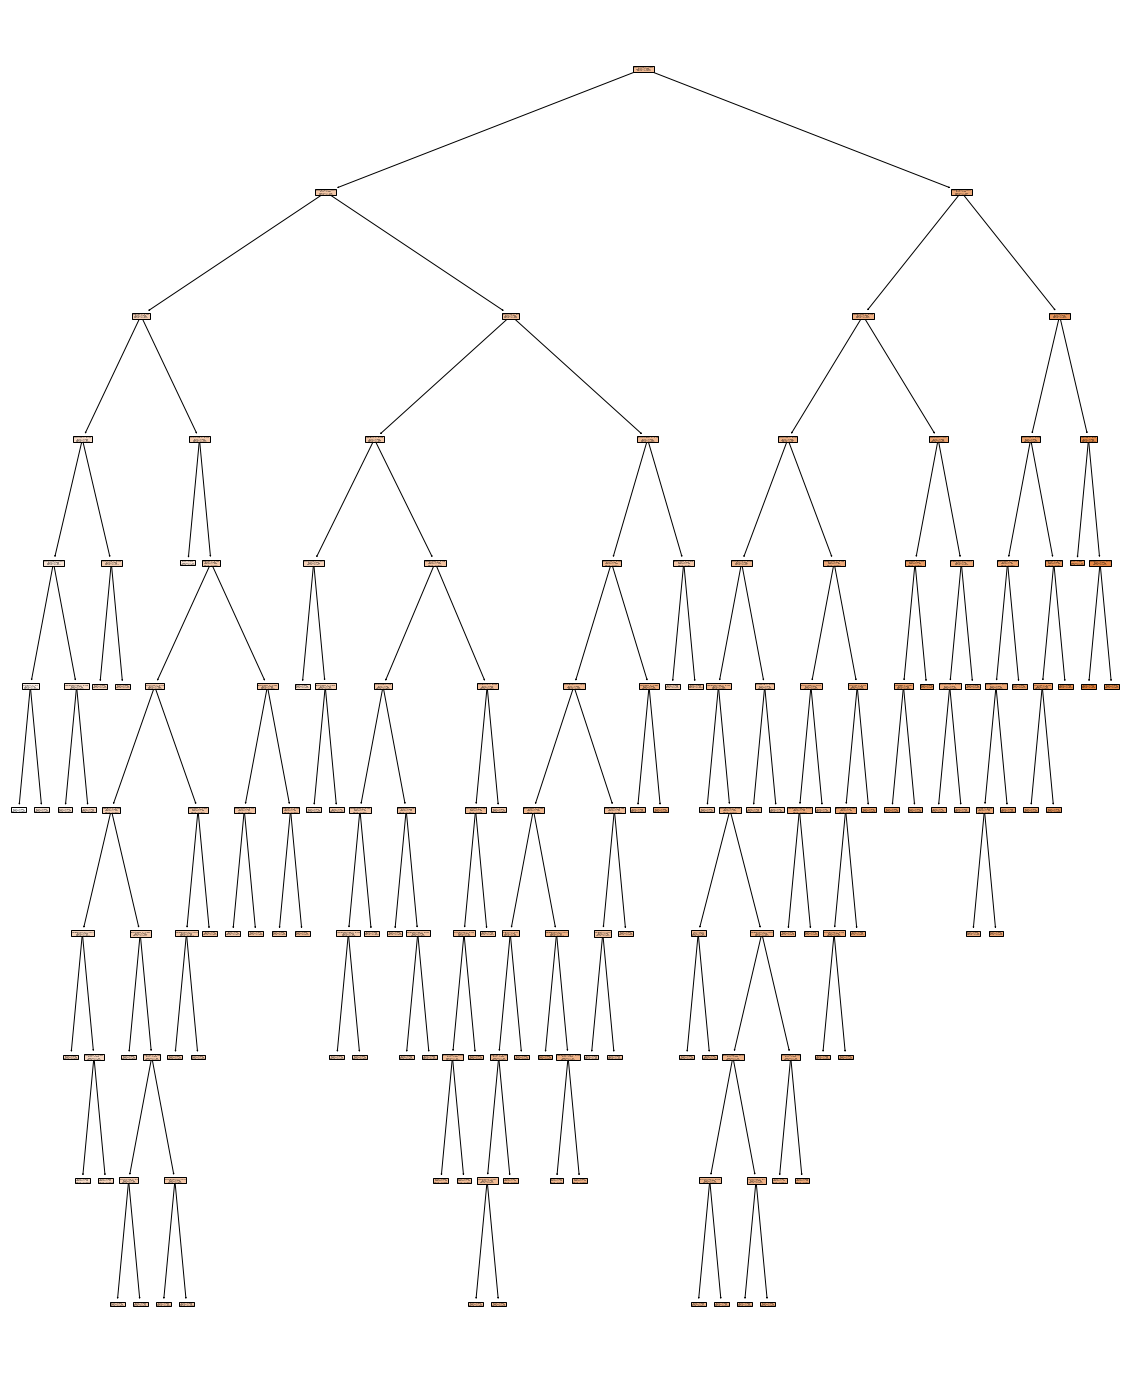

In [23]:
fig = plt.figure(figsize=(20,25))
_ = tree.plot_tree(model_tree, 
                   feature_names=cols,  
                   filled=True)

Tree visualization

Losses for decision tree

In [24]:
print(f' MAE of validation set: {mean_absolute_error(np.exp(val_target), np.exp(model_tree.predict(val_set_scaled)))}',
      '\n', f'MAE of train set: {mean_absolute_error(np.exp(target), np.exp(model_tree.predict(train_scaled)))}',
      '\n', 
      f'MSE of validation set: {mean_squared_error(np.exp(val_target), np.exp(model_tree.predict(val_set_scaled)), squared = False)}',
      '\n', f'MSE of train set: {mean_squared_error(np.exp(target), np.exp(model_tree.predict(train_scaled)), squared = False)}')

 MAE of validation set: 25527.108514416625 
 MAE of train set: 16620.40999676617 
 MSE of validation set: 40962.43792224009 
 MSE of train set: 27273.09102269542


### Important feature selection

In [25]:
dict_imp = dict(zip(cols, model_tree.feature_importances_))
list_imp = list(dict_imp.items())
list_imp.sort(key=lambda i: i[1], reverse=True)
features = []
for i in list_imp:
    if i[1] > 0.001:
        features.append(i[0])
        print(i[0], ':', i[1])

OverallQual : 0.5392415730330166
GarageCars : 0.17025444535451384
GrLivArea : 0.0872968605268522
1stFlrSF : 0.049318253539143944
TotalBsmtSF : 0.03375022800238508
YearBuilt : 0.021560946436544784
BsmtFinSF1 : 0.0172020279182648
OverallCond : 0.014717398660521052
KitchenAbvGr : 0.011542896332456348
CentralAir : 0.008119165505098985
GarageType : 0.00747644392944918
YearRemodAdd : 0.006754684579109742
Neighborhood : 0.0055018130587350484
Exterior1st : 0.0045993991240345835
GarageFinish : 0.0045842105199216
GarageArea : 0.003259232229528534
LotArea : 0.0029242868363113825
KitchenQual : 0.0029217443855787235
WoodDeckSF : 0.0027632383696190106
MSZoning : 0.0010630276213401085
HalfBath : 0.0010191654735060977


Choosin only important features from test, train and validation dataframes

In [26]:
reversed_train = pd.DataFrame(train_scaled, columns=train.columns)[features].to_numpy()
reversed_test = pd.DataFrame(test_scaled, columns=train.columns)[features].to_numpy()
reversed_val = pd.DataFrame(val_set_scaled, columns=train.columns)[features].to_numpy()

## LightGBM Regressor

I've chosen lightgbm as best ensemble model for our task

In [27]:
SPACE_lgbm = [
    Real(0.001, 0.5, name='learning_rate', prior='log-uniform'),
    Integer(1, 300, name='max_depth'),
    Integer(2, 500, name='num_leaves'),
    Integer(2, 1000, name='min_data_in_leaf'),
    Real(0.1, 0.9, name='feature_fraction'),
    Real(0.1, 0.9, name='bagging_fraction'),
    Integer(1, 500, name='bagging_freq'),
    Real(0.0, 10, name='min_gain_to_split'),
    Integer(2, 500, name='max_bin'),
    Real(0.1, 40, name='lambda_l1'),
    Real(0.1, 40, name='lambda_l2'),
    Real(1e-5, 25, name='min_sum_hessian_in_leaf'),
    Categorical(['gbdt', 'rf'], name='boosting'),
    Real(0.05, 1,name='pos_bagging_fraction'),
    Real(0.05, 1,name='neg_bagging_fraction'),
    Real(1e-5, 1,name='feature_fraction_bynode'),
    Integer(2, 500, name='min_data_per_group'),
    Integer(5, 150, name='max_cat_threshold'),
    Real(1., 50.0, name='cat_l2'),
    Real(1., 50.0, name='cat_smooth'),
    Categorical([True, False], name='use_missing'),
    Categorical(['l1', 'l2'], name='metric'),
]

In [28]:
model_lgbm = LGBMRegressor(random_state=42)
@use_named_args(SPACE_lgbm)
def objective(**params):
    model_lgbm.set_params(**params)
    return -np.mean(cross_val_score(model_lgbm, reversed_train, target, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

### Hyperparameters tuning

I've defined that Gaussian Processes is the best optimisation algorithm for this task

In [29]:
res_gp = gp_minimize(objective, SPACE_lgbm, n_calls=100, random_state=42, verbose=True)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.6797
Function value obtained: 12.0337
Current minimum: 12.0337
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0301
Function value obtained: 12.0337
Current minimum: 12.0337
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0437
Function value obtained: 12.0337
Current minimum: 12.0337
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0349
Function value obtained: 12.0337
Current minimum: 12.0337
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0298
Function value obtained: 12.0337
Current minimum: 12.0337
Iteration No: 6 started. 

/Users/nikkirpa/opt/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 1.2952
Function value obtained: 0.1123
Current minimum: 0.1119
Iteration No: 38 started. Searching for the next optimal point.
Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 1.0950
Function value obtained: 0.1194
Current minimum: 0.1119
Iteration No: 39 started. Searching for the next optimal point.
Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 1.1309
Function value obtained: 0.3069
Current minimum: 0.1119
Iteration No: 40 started. Searching for the next optimal point.
Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 1.2029
Function value obtained: 0.1123
Current minimum: 0.1119
Iteration No: 41 started. Searching for the next optimal point.
Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 1.3526
Function value obtained: 0.1077
Current minimum: 0.1077
Iteration No: 42 started. Sea

Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 1.9762
Function value obtained: 0.1041
Current minimum: 0.0989
Iteration No: 78 started. Searching for the next optimal point.
Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 1.6350
Function value obtained: 0.1062
Current minimum: 0.0989
Iteration No: 79 started. Searching for the next optimal point.
Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 1.5869
Function value obtained: 0.1086
Current minimum: 0.0989
Iteration No: 80 started. Searching for the next optimal point.
Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 1.8038
Function value obtained: 0.1172
Current minimum: 0.0989
Iteration No: 81 started. Searching for the next optimal point.
Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 1.8906
Function value obtained: 0.1381
Current minimum: 0.0989
Iteration No: 82 started. Sea

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

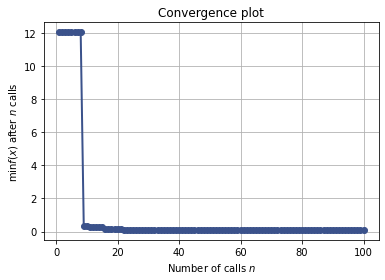

In [30]:
plot_convergence(res_gp)

Expecting the best score, model, and it's parameters

In [31]:
def to_named_params(params):
    return dict([(dimension.name, param) for dimension, param in zip(SPACE_lgbm, params)])

print('Best score is', res_gp.fun)
params = to_named_params(res_gp.x_iters[res_gp.func_vals.argmin()])
print('Can be reached with parameters:')
print(params)

Best score is 0.09893944021104546
Can be reached with parameters:
{'learning_rate': 0.3589273391940407, 'max_depth': 185, 'num_leaves': 175, 'min_data_in_leaf': 2, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'bagging_freq': 181, 'min_gain_to_split': 0.0, 'max_bin': 500, 'lambda_l1': 0.1, 'lambda_l2': 40.0, 'min_sum_hessian_in_leaf': 25.0, 'boosting': 'gbdt', 'pos_bagging_fraction': 1.0, 'neg_bagging_fraction': 1.0, 'feature_fraction_bynode': 1.0, 'min_data_per_group': 2, 'max_cat_threshold': 150, 'cat_l2': 35.170410646054684, 'cat_smooth': 45.37059081133547, 'use_missing': False, 'metric': 'l2'}


Defined method for lgbm model training using repeated KFold, returns temporary score, model itself and average test scores

In [32]:
def train_eval_model(train, target, test_numpy, params, n_splits, verbose=False):
    skf = RepeatedKFold(n_splits=n_splits, n_repeats = 5)
    test_scores = np.zeros(len(test_numpy))
    for i, (tr, val) in enumerate(skf.split(train, target)):
        model_res = {
        'test_res': [],
        'estimator' : [],
        }
        model = LGBMRegressor(random_state = 42)
        model.set_params(**params)
        
        x_train, x_val, y_train, y_val = train[tr], train[val], target[tr], target[val]
        
        model.fit(x_train, y_train)
        val_preds = model.predict(x_val)
        
        score = mean_absolute_error(y_val, val_preds)
    
        model_res['estimator'].append(model)
        test_scores += model.predict(test_numpy)
        
        if verbose:
            print('-' * 100)
            print("Score: ", score)  
            print('-' * 100)
    
    test_scores /= n_splits * skf.n_repeats
    return score, model_res, test_scores

In [33]:
score, model_res, test_scores = train_eval_model(reversed_train, target, reversed_test, params, 3, True)

[LightGBM] [Warning] bagging_freq is set=181, subsample_freq=0 will be ignored. Current value: bagging_freq=181
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=25.0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=25.0
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_sample

----------------------------------------------------------------------------------------------------
Score:  0.11156108627643788
----------------------------------------------------------------------------------------------------
[LightGBM] [Warning] bagging_freq is set=181, subsample_freq=0 will be ignored. Current value: bagging_freq=181
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Curre

----------------------------------------------------------------------------------------------------
Score:  0.1032190028597648
----------------------------------------------------------------------------------------------------
[LightGBM] [Warning] bagging_freq is set=181, subsample_freq=0 will be ignored. Current value: bagging_freq=181
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Curren

In [34]:
model_lgbm = model_res['estimator'][0]

Improvement in losses as expected

In [35]:
print(f' MAE of validation set: {mean_absolute_error(np.exp(val_target), np.exp(model_lgbm.predict(reversed_val)))}',
      '\n', f'MAE of train set: {mean_absolute_error(np.exp(target), np.exp(model_lgbm.predict(reversed_train)))}',
      '\n', 
      f'MSE of validation set: {mean_squared_error(np.exp(val_target), np.exp(model_lgbm.predict(reversed_val)), squared = False)}',
      '\n', f'MSE of train set: {mean_squared_error(np.exp(target), np.exp(model_lgbm.predict(reversed_train)), squared = False)}')

 MAE of validation set: 17100.082304145868 
 MAE of train set: 10736.042985701077 
 MSE of validation set: 29826.45573560205 
 MSE of train set: 22795.297090485947


Saving predictions

In [36]:
test['SalePrice'] = np.exp(test_scores)

In [37]:
test[['Id', 'SalePrice']].to_csv('data/prediction.csv')